In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from simulate import TaxiSimulator
from constants import (
    TIME_BLOCK_BOUNDARY,
    TAXI_INIT, 
    RIDER_ARRIVAL,
    RIDE_START, 
    RIDER_LOST,
    RIDE_COMPLETION, 
    RELOCATION_START, 
    RELOCATION_COMPLETION
)

np.set_printoptions(suppress=True)

In [2]:
# Simulation parameters
Delta = 20 # in minutes

Use actual parameters

In [3]:
with np.load('../nyc_trip/trip_counts.npz') as data:
    trip_counts = data['trip_counts']
    num_dates = data['num_dates']

with np.load('../nyc_trip/mu_cp.npz') as data:
    mu_ = data['mu']
    
# mask trip_counts by 1 where 0
trip_counts[trip_counts == 0] = 1

# compute arrival rate
lambda_ = trip_counts.sum(axis=2) / (Delta / 60 * num_dates)

# normalize trip_counts
P = trip_counts / trip_counts.sum(axis=2, keepdims=True)

# load time-dependent relocation matrix
with np.load('../nyc_trip/Qs.npz') as data:
    Q = data['Qs']

T, R, _ = P.shape

Q_base = np.array([np.identity(R) for _ in range(T)])

In [29]:
max_time = 48  # Simulate 72 hours
N = 8000

# Initialize and run the simulator
sim = TaxiSimulator(T=T, R=R, N=N, lambda_=lambda_, mu_=mu_, P=P, Q=Q)
sim.run(max_time=max_time)
df_log = pd.DataFrame(sim.logger)

# Base relocation strategy
sim_base = TaxiSimulator(T=T, R=R, N=N, lambda_=lambda_, mu_=mu_, P=P, Q=Q_base)
sim_base.run(max_time=max_time)
df_base_log = pd.DataFrame(sim_base.logger)

In [30]:
start_time = pd.Timestamp('2025-01-02 00:00:00')

df_log = df_log[df_log.event_type != TIME_BLOCK_BOUNDARY].reset_index(drop=True)
df_log['datetime'] = start_time + pd.to_timedelta(df_log['time'], unit='h')

df_base_log = df_base_log[df_base_log.event_type != TIME_BLOCK_BOUNDARY].reset_index(drop=True)
df_base_log['datetime'] = start_time + pd.to_timedelta(df_base_log['time'], unit='h')

In [ ]:
def get_rider_arrival_timeseries(df_log, region_id, bin_minutes=20):
    arrivals = df_log[df_log['event_type'] == RIDER_ARRIVAL].copy()
    arrivals['region'] = arrivals['data'].apply(lambda x: x['region'])
    arrivals = arrivals[arrivals['region'] == region_id]

    arrivals['time_bin'] = arrivals['datetime'].dt.floor(f'{bin_minutes}min')
    arrival_counts = arrivals.groupby('time_bin').size().reset_index(name='num_arrivals')

    return arrival_counts

def get_ridestarts_timeseries(df_log, region_id, bin_minutes=20):
    ride_starts = df_log[df_log['event_type'] == RIDE_START].copy()
    ride_starts['region'] = ride_starts['data'].apply(lambda x: x['origin'])
    ride_starts = ride_starts[ride_starts['region'] == region_id]

    ride_starts['time_bin'] = ride_starts['datetime'].dt.floor(f'{bin_minutes}min')
    ride_starts = ride_starts.groupby('time_bin').size().reset_index(name='num_ridestarts')

    return ride_starts

def get_rider_lost_timeseries(df_log, region_id, bin_minutes=20):
    lost_rides = df_log[df_log['event_type'] == RIDER_LOST].copy()
    lost_rides['region'] = lost_rides['data'].apply(lambda x: x['region'])
    lost_rides = lost_rides[lost_rides['region'] == region_id]

    lost_rides['time_bin'] = lost_rides['datetime'].dt.floor(f'{bin_minutes}min')
    lost_rides = lost_rides.groupby('time_bin').size().reset_index(name='num_lost_rides')

    return lost_rides

def fill_missing_time_bins(df_timeseries, start_time, end_time, bin_minutes=20, count_col='num_lost_rides'):
    full_time_index = pd.date_range(start=start_time, end=end_time, freq=f'{bin_minutes}min')
    full_df = pd.DataFrame({'time_bin': full_time_index})
    merged = full_df.merge(df_timeseries, on='time_bin', how='left')
    merged[count_col] = merged[count_col].fillna(0).astype(int)
    return merged

def plot_arrival_versus_ridestarts(df_log, region_id, bin_minutes):
    arrival_ts = get_rider_arrival_timeseries(df_log, region_id=region_id, bin_minutes=bin_minutes)
    ridestarts_ts = get_ridestarts_timeseries(df_log, region_id=region_id, bin_minutes=bin_minutes)
    lostrides_ts = get_rider_lost_timeseries(df_log, region_id=region_id, bin_minutes=bin_minutes)

    start_time = arrival_ts['time_bin'].min()
    end_time = arrival_ts['time_bin'].max()

    arrival_ts = fill_missing_time_bins(
        arrival_ts,
        start_time=start_time,
        end_time=end_time,
        bin_minutes=bin_minutes,
        count_col='num_arrivals'
    )

    ridestarts_ts = fill_missing_time_bins(
        ridestarts_ts,
        start_time=start_time,
        end_time=end_time,
        bin_minutes=bin_minutes,
        count_col='num_ridestarts'
    )
    
    lostrides_ts = fill_missing_time_bins(
        lostrides_ts,
        start_time=start_time,
        end_time=end_time,
        bin_minutes=bin_minutes,
        count_col='num_lost_rides'
    )
    
    # arrival_ts['num_ridestart'] = arrival_ts['num_arrivals'] - riderlost_ts['num_lost_rides']

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    plt.plot(arrival_ts['time_bin'], arrival_ts['num_arrivals'], label='Rider Arrivals', color='blue')
    plt.plot(ridestarts_ts['time_bin'], ridestarts_ts['num_ridestarts'], label='Ride Starts', color='orange')
    plt.plot(lostrides_ts['time_bin'], lostrides_ts['num_lost_rides'], label='Riders Lost', color='purple')
    plt.title('Rider Arrivals/Starts/Lost Rides Over Time')
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

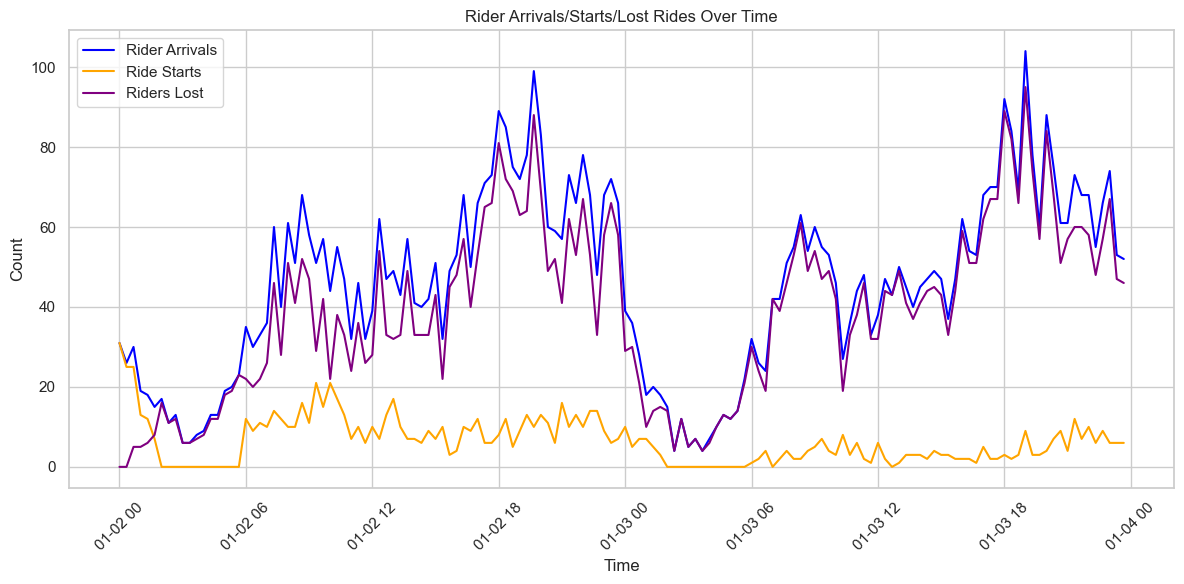

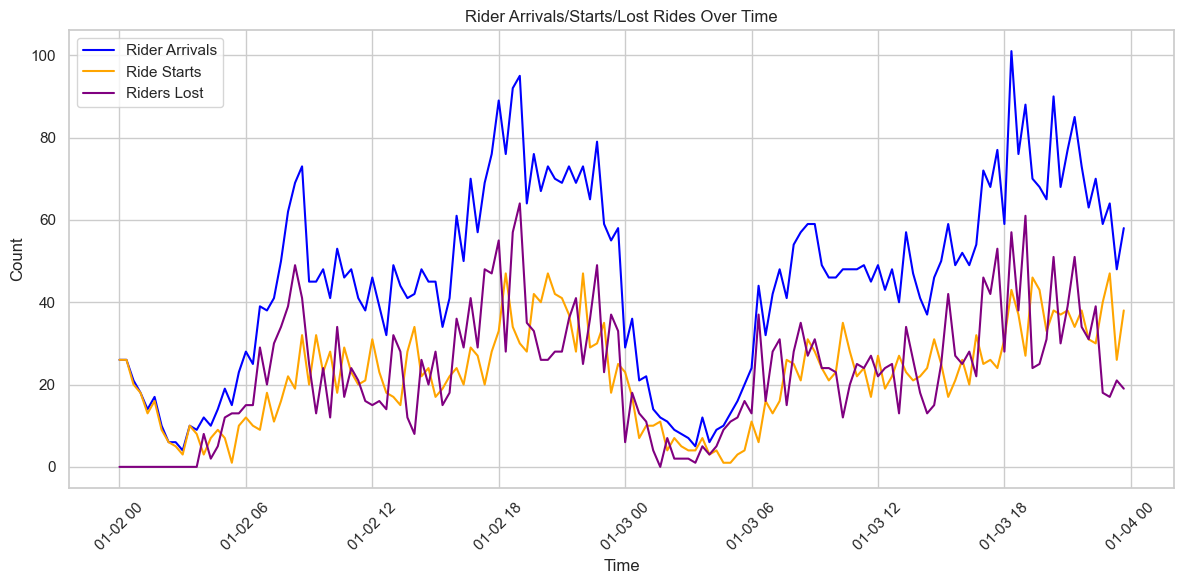

In [69]:
region_id = 78

plot_arrival_versus_ridestarts(df_log=df_log, region_id=region_id, bin_minutes=20)
plot_arrival_versus_ridestarts(df_log=df_base_log, region_id=region_id, bin_minutes=20)

In [58]:
len(df_log[df_log.event_type == RIDE_START]), len(df_base_log[df_base_log.event_type == RIDE_START])

(236340, 559785)